<a href="https://colab.research.google.com/github/LucienCastle/diabetes-patient-readmission-prediction/blob/main/Readmission_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/diabetes+130-us+hospitals+for+years+1999-2008.zip

Archive:  /content/diabetes+130-us+hospitals+for+years+1999-2008.zip
  inflating: diabetic_data.csv       
  inflating: IDS_mapping.csv         


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Data Exploration and Analysis

In [3]:
diabetes_df = pd.read_csv('/content/diabetic_data.csv')
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# overview of the attributes
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [7]:
# check target variable
diabetes_df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

In [13]:
# checking discharge deposition ID, which tells us situation of patient after being hospitalized
diabetes_df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

In [15]:
# Removing samples with ids = [11,13,14,19,20,21] as they are related to death accoring to the IDS_mapping
diabetes_df = diabetes_df.loc[~diabetes_df.discharge_disposition_id.isin([11, 13, 14, 19, 20, 21])]

In [16]:
# Defining a target variable to predict if a patient will be readmitted within 30 Days or not
diabetes_df['readmission_status'] = (diabetes_df.readmitted == '<30').astype('int')

In [21]:
# Calculating prevalence of patients readmitted within 30 days
def calc_prev(
    target: np.ndarray
)->float:
  return sum(target)/len(target)

print('Prevalence: %.3f'%calc_prev(diabetes_df['readmission_status'].values))


Prevalence: 0.114


In [24]:
# Looking at unique values for each of the columns
for col in list(diabetes_df.columns):
    n = diabetes_df[col].unique()

    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(f'{col} : {n}')
    else:
        print(col + ': ' +str(len(n)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race : ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender : ['Female' 'Male' 'Unknown/Invalid']
age : ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight : ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id : [6 1 2 3 4 5 8 7]
discharge_disposition_id : [25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id : [ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital : [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code : ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures : [0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpati

From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out,

- encounter_id and patient_nbr: these are just identifiers and not useful variables
- age and weight: are categorical in this data set
- admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical.
- examide and citoglipton only have 1 value, so we will not use these variables
- diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information.
- medical_speciality - has many categorical variables, so we should consider this when making features.

## 2. Feature Engineering

In [25]:
# replace ? with nan
diabetes_df = diabetes_df.replace('?',np.nan)

In [26]:
# Checking any numeric columns with null values
cols_num = [
    'time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses'
    ]
diabetes_df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

In [28]:
# Checking null values in categorical features

cols_cat = [
    'race', 'gender', 'max_glu_serum', 'A1Cresult',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed','payer_code'
  ]
diabetes_df[cols_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

`race`, `payer_code`, and `medical_specialty` have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the fillna function.

In [29]:
diabetes_df['race'] = diabetes_df['race'].fillna('UNK')
diabetes_df['payer_code'] = diabetes_df['payer_code'].fillna('UNK')
diabetes_df['medical_specialty'] = diabetes_df['medical_specialty'].fillna('UNK')

In [30]:
print('Number medical specialty:', diabetes_df.medical_specialty.nunique())
diabetes_df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Dermatology                             1
Proctology                              1
Psychiatry-Addictive                    1
Speech                                  1
Length: 73, dtype: int64

We can see that most of them are unknown and that the count drops off pretty quickly. We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category). Obviously, there are other options for bucketing, but this is one of the easiest methods

In [31]:
top_10 = [
    'UNK','InternalMedicine','Emergency/Trauma',
    'Family/GeneralPractice', 'Cardiology','Surgery-General',
    'Nephrology','Orthopedics', 'Orthopedics-Reconstructive',
    'Radiologist'
  ]

# make a new column with duplicated data
diabetes_df['med_spec'] = diabetes_df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
diabetes_df.loc[~diabetes_df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [32]:
diabetes_df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

To convert our categorical features to numbers, we will use a one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. To create these one-hot encoding columns, we can use the get_dummies function.

Now the problem is that if we create a column for each unique value, we have correlated columns. In other words, the value in one column can be figured out by looking at the rest of the columns. For example, if the sample is not AfricanAmerican, Asian, Causasian, Hispance or Other, it must be UNK. To deal with this, we can use the drop_first option, which will drop the first categorical value for each column.

The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly.

In [34]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

diabetes_df[cols_cat_num] = diabetes_df[cols_cat_num].astype('str')

In [35]:
df_cat = pd.get_dummies(diabetes_df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [36]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
enc_diabetes_df = pd.concat([diabetes_df,df_cat], axis = 1)

In [38]:
cols_all_cat = list(df_cat.columns)

In [40]:
enc_diabetes_df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


In [43]:
enc_diabetes_df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

In [44]:
age_id = {'[0-10)':0,
          '[10-20)':10,
          '[20-30)':20,
          '[30-40)':30,
          '[40-50)':40,
          '[50-60)':50,
          '[60-70)':60,
          '[70-80)':70,
          '[80-90)':80,
          '[90-100)':90}
enc_diabetes_df['age_group'] = enc_diabetes_df.age.replace(age_id)

In [45]:
enc_diabetes_df.weight.notnull().sum()

3125

In [46]:
enc_diabetes_df['has_weight'] = enc_diabetes_df.weight.notnull().astype('int')

In [47]:
cols_extra = ['age_group','has_weight']

In [48]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


In [49]:
enc_diabetes_df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

time_in_hospital               0
discharge_disposition_id_16    0
admission_type_id_6            0
admission_type_id_7            0
admission_type_id_8            0
discharge_disposition_id_10    0
discharge_disposition_id_12    0
discharge_disposition_id_15    0
discharge_disposition_id_17    0
admission_type_id_4            0
dtype: int64

In [50]:
col2use = cols_num + cols_all_cat + cols_extra
df_data = enc_diabetes_df[col2use + ['readmission_status']]

## 3. Building Training/Validation/Test Samples
So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split into three parts: - Training samples: these samples are used to train the model - Validation samples: these samples are held out from the training data and are used to make decisions on how to improve the model - Test samples: these samples are held out from all decisions and are used to measure the generalized performance of the model

In this project, we will split into 70% train, 15% validation, 15% test.

The first thing I like to do is to shuffle the samples using sample in case there was some order (e.g. all positive samples on top). Here n is the number. random_state is just specified so the entire class gets the same shuffling. You wouldn't need random_state in your own projects.

In [51]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

In [52]:
# Save 30% of the data as validation and test data
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [53]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

In [55]:
# use the rest of the data as training data
df_train_all = df_data.drop(df_valid_test.index)

In [56]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prev(df_test.readmission_status.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prev(df_valid.readmission_status.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prev(df_train_all.readmission_status.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


In [57]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 99343)


At this point, you might say, drop the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. Great! Good job! But wait, we never catch any of the readmissions (recall= 0%). How can this happen?

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative.

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized: - sub-sample the more dominant class: use a random subset of the negatives - over-sample the imbalanced class: use the same positive samples multiple times - create synthetic positive data

Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement.

In [58]:
# split the training data into positive and negative
rows_pos = df_train_all.readmission_status == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prev(df_train.readmission_status.values)))

Train balanced prevalence(n = 15766):0.500


In [59]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [60]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['readmission_status'].values
y_valid = df_valid['readmission_status'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


In [61]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [62]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [63]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [64]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

## 4. Modelling

In [70]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):

    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC: %.3f'%auc)
    print('accuracy: %.3f'%accuracy)
    print('recall: %.3f'%recall)
    print('precision: %.3f'%precision)
    print('specificity: %.3f'%specificity)
    print('prevalence: %.3f'%calc_prev(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [67]:
thresh = 0.5

### K Nearest Neighbors

In [68]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [73]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('                               KNN                                      ')
print('------------------------------------------------------------------------')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

                               KNN                                      
------------------------------------------------------------------------
Training:
AUC: 0.650
accuracy: 0.603
recall: 0.491
precision: 0.633
specificity: 0.673
prevalence: 0.500
 
Validation:
AUC: 0.621
accuracy: 0.670
recall: 0.469
precision: 0.165
specificity: 0.655
prevalence: 0.113
 


### Logistic Regression

In [75]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [76]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('                        Logistic Regression                             ')
print('------------------------------------------------------------------------')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

                        Logistic Regression                             
------------------------------------------------------------------------
Training:
AUC: 0.678
accuracy: 0.628
recall: 0.558
precision: 0.649
specificity: 0.698
prevalence: 0.500
 
Validation:
AUC: 0.661
accuracy: 0.662
recall: 0.558
precision: 0.180
specificity: 0.675
prevalence: 0.113
 


### Stochastic Gradient Descent

In [77]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(loss='log', alpha=0.1, random_state=42)
sgdc.fit(X_train_tf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [78]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('                    Stochastic Gradient Descent                         ')
print('------------------------------------------------------------------------')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

                    Stochastic Gradient Descent                         
------------------------------------------------------------------------
Training:
AUC: 0.676
accuracy: 0.624
recall: 0.550
precision: 0.645
specificity: 0.698
prevalence: 0.500
 
Validation:
AUC: 0.661
accuracy: 0.664
recall: 0.553
precision: 0.180
specificity: 0.678
prevalence: 0.113
 


### Gausian Naive Bayes

In [79]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [80]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('                          Gaussian Naive Bayes                          ')
print('------------------------------------------------------------------------')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

                          Gaussian Naive Bayes                          
------------------------------------------------------------------------
Training:
AUC: 0.508
accuracy: 0.506
recall: 0.989
precision: 0.503
specificity: 0.022
prevalence: 0.500
 
Validation:
AUC: 0.505
accuracy: 0.129
recall: 0.988
precision: 0.114
specificity: 0.020
prevalence: 0.113
 


### Decision Tree

In [81]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=10, random_state=42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [82]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('                             Decision Trees                             ')
print('------------------------------------------------------------------------')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

                             Decision Trees                             
------------------------------------------------------------------------
Training:
AUC: 0.736
accuracy: 0.672
recall: 0.629
precision: 0.688
specificity: 0.713
prevalence: 0.500
 
Validation:
AUC: 0.623
accuracy: 0.636
recall: 0.570
precision: 0.170
specificity: 0.642
prevalence: 0.113
 


### Random Forest

In [83]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=6, random_state=42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [84]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('                             Random Forest                              ')
print('------------------------------------------------------------------------')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

                             Random Forest                              
------------------------------------------------------------------------
Training:
AUC: 0.696
accuracy: 0.643
recall: 0.612
precision: 0.652
specificity: 0.673
prevalence: 0.500
 
Validation:
AUC: 0.657
accuracy: 0.629
recall: 0.604
precision: 0.173
specificity: 0.633
prevalence: 0.113
 


## Gradient Boosting Classifier

In [85]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=1.0,
    max_depth=3,
    random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [86]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('                      Gradient Boosting Classifier                      ')
print('------------------------------------------------------------------------')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

                      Gradient Boosting Classifier                      
------------------------------------------------------------------------
Training:
AUC: 0.772
accuracy: 0.695
recall: 0.668
precision: 0.706
specificity: 0.722
prevalence: 0.500
 
Validation:
AUC: 0.638
accuracy: 0.620
recall: 0.574
precision: 0.164
specificity: 0.626
prevalence: 0.113
 


## Analyze results baseline models
Let's make a dataframe with these results and plot the outcomes using a package called seaborn. In this project, we will utilize the Area under the ROC curve (AUC) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold.

In [87]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

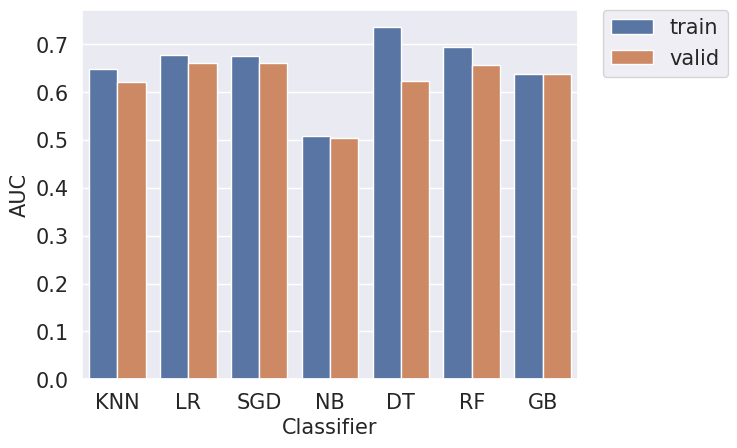

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

## 6. Model Selection

In [90]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

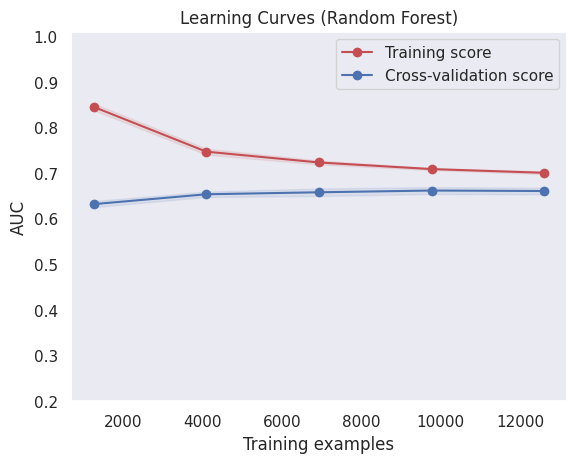

In [91]:
title = "Learning Curves (Random Forest)"

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the case of random forest, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting.

Depending on your learning curve, there are a few strategies you can employ to improve your models

High Bias:
- Add new features
- Increase model complexity
- Reduce regularization
- Change model architecture

High Variance:
- Add more samples
- Add regularization
- Reduce number of features
- Decrease model complexity
- Add better features
- Change model architecture

### Feature Importance
One path for improving your models to understand what features are important to your models. This can usually only be investigated for simpler models such as Logistic Regression or Random Forests. This analysis can help in a few areas:

- inspire new feature ideas --> helps with both high bias and high variance
- obtain a list of the top features to be used for feature reduction --> helps with high variance
- point out errors in your pipeline --> helps with robustness of model

Let's get the feature importance for a few models and then we can discuss what we see.

#### Feature Importance: Logistic regression
Logistic regression is a very interpretable model because the coefficient for each variable shows how important that variable is for the prediction. Note that you need to have normalized the data so the coefficients are comparable between variables. We can extract the coefficients using coef_ and store in a new dataframe (sorted by importance)

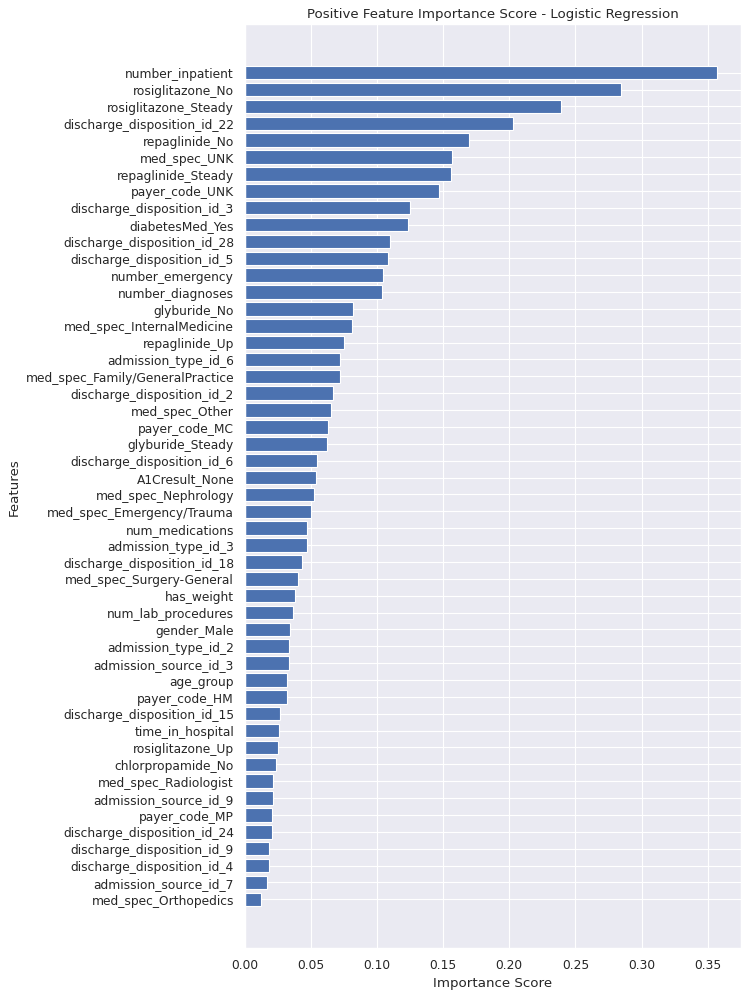

In [93]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index=col2use,
                                   columns=['importance']).sort_values('importance',
                                                                      ascending=False)

num = 50
ylocs = np.arange(num)

values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

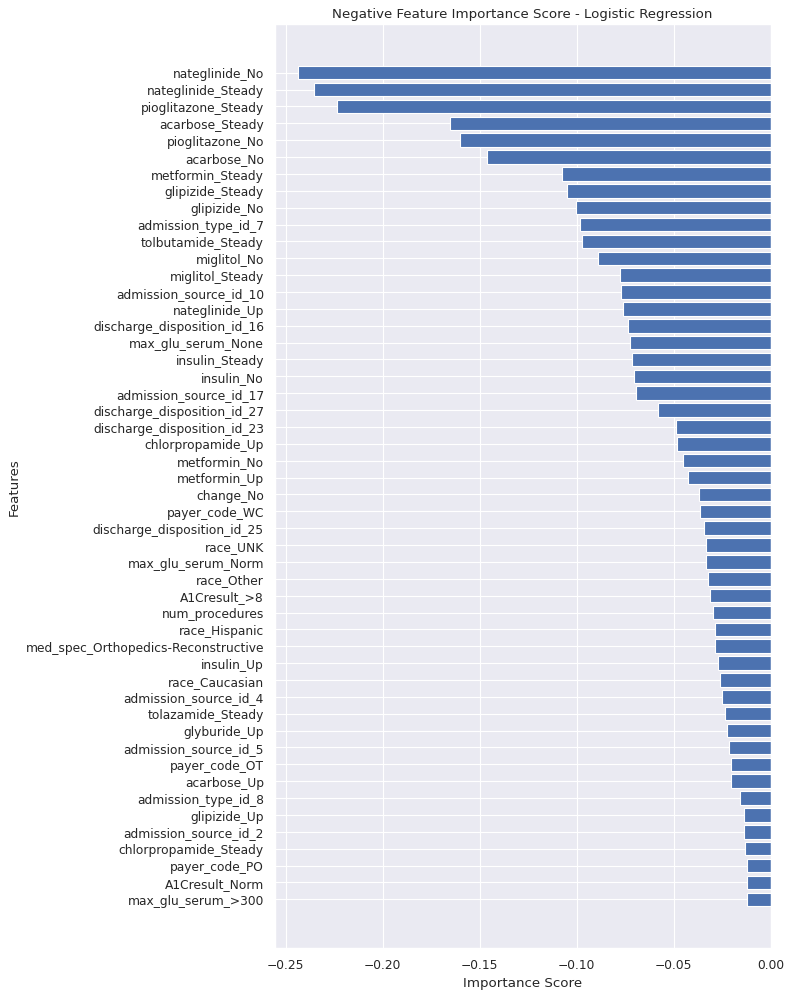

In [94]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

#### Feature Importance: random forest
We can also investigate feature importance for random forest models. In this case, the feature importance shows how often a particular feature was used to split the data. In this case, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision.

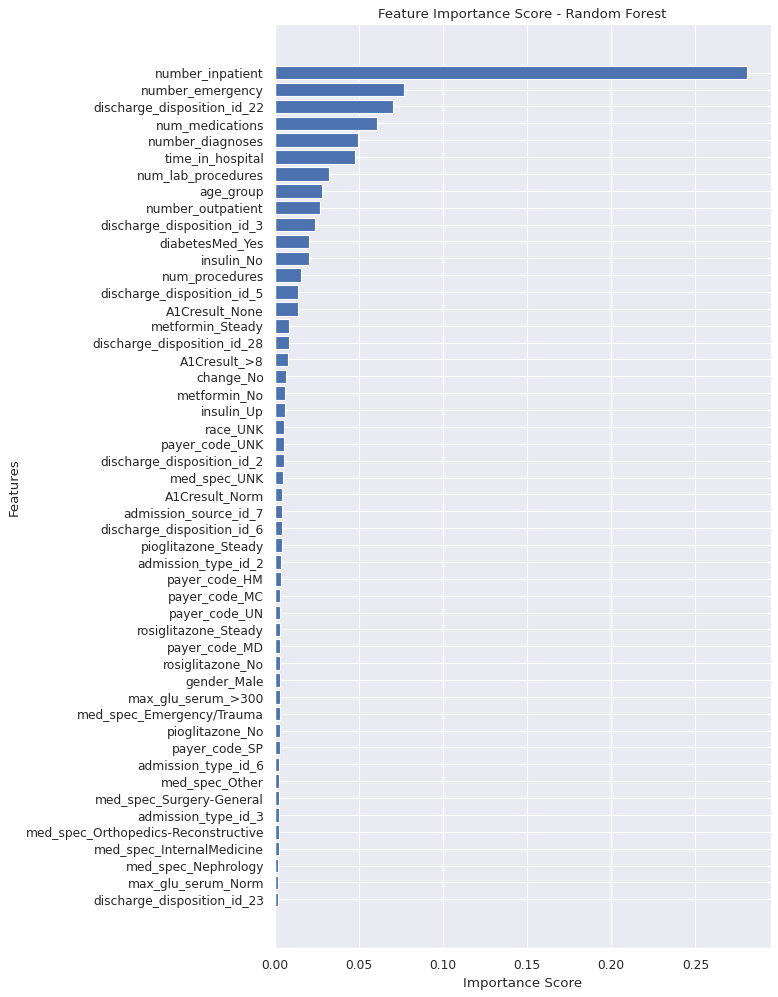

In [95]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=col2use,
                                   columns=['importance']).sort_values('importance',
                                                                        ascending=False)

num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

### Feature Importance:Summary
After reviewing these plots, you might be inspired to get some new data related to the most important features. For example, in both models the most important feature is number_inpatient, which is the number of inpatient visits in the last year. This means that if patients have been to the hospital in the last year they are more likely to be re-hospitalized again. This might inspire you to get (if you have it) more data about their prior admissions.Another example is discharge_disposition_id_22 which is used if a patient is discharged to a rehab facility. For your company, you might be able to research rules for being discharged to a rehab facility and add features related to those rules. Since most of the data analysts / data scientists won't have the deep domain knowledge. I probably would take a few of these features to other experts (e.g. doctors) and ask them about the medications.

In the case of high variance, one strategy is to reduce the number of variables to minimize overfitting. After this analyis, you could use the top N positive and negative features or the top N important random forest features. You might need to adjust N so that your performance does not drop drastically. For example, only using the top feature will likely drop the performance by a lot. Another strategy that you could use to reduce the number of variables is called PCA (principle component analysis). This is also implemented in scikit-learn if you are interested.

The last thing that I want to mention is that the feature importance plots may also point out errors in your predictive model. Perhaps, you have some data leakage in the cleaning process. Data leakage can be thought of as the process of accidentally including something in the training that allows the machine learning algorithm to artificially cheat. For example, I built a model based on the doctor's discharge notes. When I performed this same analysis on the most important words, I discovered that the top word for predicting someone would not be re-admitted was 'death'. This made me realize that I made a mistake and forgot to exclude patients who expired in the current hospital visit. Learning from my mistakes, I had you exclude the discharge codes related to death. Similar things can also happen when you merge datasets. Perhaps when you merged the datasets one of the classes ended up with nan for some of the variables. The analysis above will help you catch some of these cases.

### Hyperparameter tuning
The next thing that we should investigate is hyperparameter tuning. Hyperparameter tuning are essentially the design decisions that you made when you set up the machine learning model. For example, what is the maximum depth for your random forest? Each of these hyperparameters can be optimized to improve the model.

In this section, we will only optimize the hyper parameters for stochastic gradient descent, random forest and gradient boosting classifier. We will not optimize KNN since it took a while to train. We will not optimize Logistic regression since it performs similarly to stochastic gradient descent. We will not optimize decision trees since they tend to overfit and perform worse that random forests and gradient boosting classifiers.

one technique for hyperparameter tuning is called a Grid search where you test all possible combinations over a grid of values. This is very computationally intensive. The other option is to randomly test a permutation of them. This technique called Random Search is also implemented in scikit-learn.

#### Hyperparameter Tuning: Random Forest

In [96]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [97]:
from sklearn.model_selection import RandomizedSearchCV

# number of trees
n_estimators = range(200, 1000, 200)

# maximum number of features to use at each split
max_features = ['auto', 'sqrt']

# maximum depth of the tree
max_depth = range(1, 10, 1)

# minimum number of samples to split a node
min_samples_split = range(2, 10, 2)

# criterion for evaluating a split
criterion = ['gini', 'entropy']

# random grid
random_grid = {
              'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion
              }

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 10), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [98]:
from sklearn.metrics import make_scorer, roc_auc_score
auc_scoring = make_scorer(roc_auc_score)

In [100]:
# create the randomized search cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=20,
    cv=2,
    scoring=auc_scoring,
    verbose=1,
    random_state=42
)

In [ ]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

In [102]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy'}

In [103]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_auc_base = roc_auc_score(y_train, y_train_preds)
rf_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_auc_base))
print('Validation AUC:%.3f'%(rf_valid_auc_base))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_auc))
print('Validation AUC:%.3f'%(rf_valid_auc))

Baseline Random Forest
Training AUC:0.696
Validation AUC:0.657
Optimized Random Forest
Training AUC:0.717
Validation AUC:0.660


#### Hyperparameter Tuning: Stochastic Gradient Descent

In [ ]:
penalty = ['elasticnet', 'l2', 'l1']
max_iter = range(100, 500, 100)
alpha = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
random_grid_sgdc = {
    'penalty':penalty,
    'max_iter':max_iter,
    'alpha':alpha
}

# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator=sgdc, param_distributions=random_grid_sgdc, n_iter=20, cv=2, scoring=auc_scoring, verbose=0, random_state=42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

In [106]:
sgdc_random.best_params_

{'penalty': 'elasticnet', 'max_iter': 400, 'alpha': 0.03}

In [107]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Baseline sgdc')
sgdc_train_auc_base = roc_auc_score(y_train, y_train_preds)
sgdc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(sgdc_train_auc_base))
print('Validation AUC:%.3f'%(sgdc_valid_auc_base))
print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_auc))
print('Validation AUC:%.3f'%(sgdc_valid_auc))

Baseline sgdc
Training AUC:0.676
Validation AUC:0.661
Optimized sgdc
Training AUC:0.671
Validation AUC:0.666


In [108]:
# number of trees
n_estimators = range(100, 500, 100)

# maximum depth of the tree
max_depth = range(1, 5, 1)

# learning rate
learning_rate = [0.001, 0.01, 0.1]

# random grid
random_grid_gbc = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate
}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator=gbc, param_distributions=random_grid_gbc, n_iter=20, cv=2, scoring=auc_scoring, verbose=0, random_state=42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

342.53657841682434


In [109]:
gbc_random.best_params_

{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

In [110]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline gbc')
gbc_train_auc_base = roc_auc_score(y_train, y_train_preds)
gbc_valid_auc_base = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(gbc_train_auc_base))
print('Validation AUC:%.3f'%(gbc_valid_auc_base))

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(gbc_train_auc))
print('Validation AUC:%.3f'%(gbc_valid_auc))

Baseline gbc
Training AUC:0.772
Validation AUC:0.638
Optimized gbc
Training AUC:0.698
Validation AUC:0.669


### Hyperparameter Tuning: Results

In [111]:
df_results = pd.DataFrame({'classifier':['SGD', 'SGD', 'RF', 'RF', 'GB', 'GB'],
                           'data_set':['base', 'optimized']*3,
                           'auc':[
                              sgdc_valid_auc_base, sgdc_valid_auc,
                              rf_valid_auc_base, rf_valid_auc,
                              gbc_valid_auc_base, gbc_valid_auc,],
                          })

In [116]:
df_results

,classifier,data_set,auc
0,SGD,base,0.661396
1,SGD,optimized,0.666158
2,RF,base,0.656987
3,RF,optimized,0.660430
4,GB,base,0.638416
5,GB,optimized,0.669269


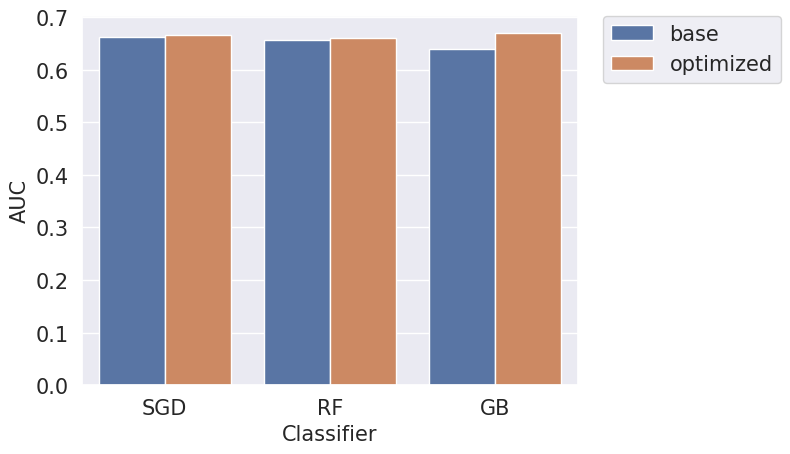

In [113]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

### Best Classifier

In [114]:
pickle.dump(gbc_random.best_estimator_, open('best_classifier.pkl', 'wb'), protocol=4)

## 7. Model Evalutaion

In [117]:
X_test = df_test[col2use].values
y_test = df_test['readmission_status'].values

scaler = pickle.load(open('scaler.sav', 'rb'))
X_test_tf = scaler.transform(X_test)

In [118]:
best_model = pickle.load(open('best_classifier.pkl','rb'))

In [119]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [120]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train, y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid, y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test, y_test_preds, thresh)

Training:
AUC: 0.698
accuracy: 0.642
recall: 0.584
precision: 0.660
specificity: 0.699
prevalence: 0.500
 
Validation:
AUC: 0.669
accuracy: 0.661
recall: 0.574
precision: 0.182
specificity: 0.672
prevalence: 0.113
 
Test:
AUC: 0.666
accuracy: 0.653
recall: 0.576
precision: 0.185
specificity: 0.664
prevalence: 0.117
 


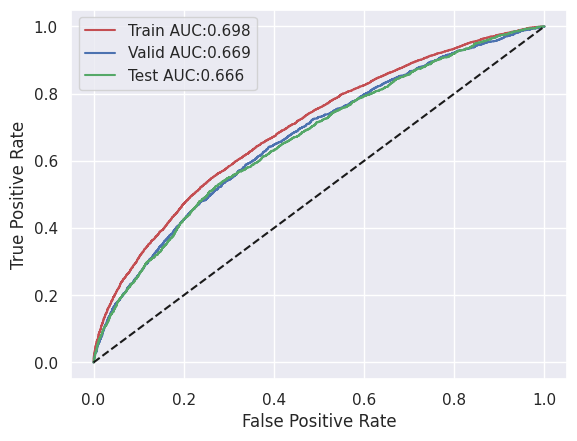

In [121]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-', label='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label='Test AUC:%.3f'%auc_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 8. Conclusion
Through this project, we created a binary classifier to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. On held out test data, our best model had an AUC of of 0.67. Using this model, we are able to catch 58% of the readmissions from our model that performs approximately 1.5 times better than randomly selecting patients.